In [1]:
import sys,os
import torch
import yaml
import logging
import pytorch_lightning as pl
from pydantic import ValidationError

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.CiT.datasets.dataset import CustomDataset
from models.CiT.training.configs import TrainingConfig
from models.CiT.training.configs import TrainingRunConfig

def get_normal_dataset(config: TrainingConfig):
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    vars = config.air_variable + config.surface_variable + config.only_input_variable + config.constant_variable

    weather = WeatherDataset(config.train_start, config.train_end, device=device, download_variables=vars, download_levels=config.levels)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    
    source, mean_std, var_vocab = weather.load_one(config.air_variable, config.surface_variable, config.only_input_variable, 
                                        config.constant_variable, level=config.levels)
    
    var_list = var_vocab.get_code(vars)
    print(var_list)
    dataset = CustomDataset(source, var_list, config.time_len, config.max_lead_time)
    return dataset, mean_std, var_list

config_path = os.path.join(os.path.dirname(os.getcwd()), 'configs/train_config.yaml')

try:
    with open(config_path) as f:
        config_dict = yaml.safe_load(f)
    config: TrainingRunConfig = TrainingRunConfig.parse_obj(config_dict)
except FileNotFoundError:
    logging.error(f"Config file {config_path} does not exist. Exiting.")
except yaml.YAMLError:
    logging.error(f"Config file {config_path} is not valid YAML. Exiting.")
except ValidationError as e:
    logging.error(f"Config file {config_path} is not valid. Exiting.\n{e}")
else:
    pl.seed_everything(config.seed)


dataset, mean_std, var_list = get_normal_dataset(config.training)

Seed set to 123


데이터셋 불러오는 중...
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                  (time: 87649, latitude: 36, longitude: 36, level: 8)
Coordinates:
  * latitude                 (latitude) float64 20.04 20.74 ... 43.95 44.65
  * level                    (level) int64 50 100 250 500 600 700 850 925
  * longitude                (longitude) float64 115.3 116.0 ... 139.2 139.9
  * time                     (time) datetime64[ns] 2013-01-01 ... 2023-01-01
Data variables:
    10m_u_component_of_wind  (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    10m_v_component_of_wind  (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    2m_temperature           (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    geopotential             (time, level, latitude, longitude) float32 dask.array<chunksize=(256, 8, 36, 36), meta=np.ndarray>
    mean_sea_level_pressure  (time, latitude, l

100%|██████████| 12/12 [00:39<00:00,  3.32s/it]


45.92939 sec
tensor([ 0,  1,  2,  3,  4,  5,  6,  7, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 56, 57, 61, 63, 64])


In [2]:
%load_ext autoreload
%autoreload 2

from models.CiT.training.lightning import TrainModule

model = TrainModule.load_from_checkpoint('/workspace/Haea_dev/models/CiT/tb_logs/lightning_logs/g23jon4x/checkpoints/epoch=17-step=78876.ckpt')

/workspace/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [3]:
from torch.utils.data import DataLoader, Dataset
import tqdm

data_loader = DataLoader(dataset, batch_size=36, shuffle=False, num_workers=8)
errors = {key: [] for key in range(config.training.max_lead_time+1)}
epoch = 1
model.setting()

for i, batch in enumerate(tqdm.tqdm(data_loader)):
        rmse_loss, delta = model(batch)
        # loss.shape = (batch, var_len)
        for i, d in enumerate(delta):
            errors[d.item()].append(rmse_loss[i])

  0%|          | 0/2435 [00:00<?, ?it/s]

 98%|█████████▊| 2387/2435 [45:10<00:53,  1.12s/it]

In [ ]:
print()

In [10]:
sample = torch.arange(config.training.time_len, config.training.max_lead_time, step=config.training.time_len, dtype=torch.int32)
result = torch.zeros(len(sample), len(var_list), config.training.time_len)

for i in range(sample.size(0)):
    key = sample[i].item()
    error = torch.stack(errors[key], dim=0)
    print(errors.shape)

RuntimeError: stack expects each tensor to be equal size, but got [36, 24] at entry 0 and [25, 24] at entry 7339

: 

In [5]:
# shape = (lead_time, count, var_len)
result = torch.zeros(config.training.max_lead_time, len(var_list))

for time in errors.keys():
    if len(errors[time]) > 0:
        mean = torch.stack(errors[time], dim=0).mean(dim=0)
        result[time] = mean

result = result.swapaxes(0, 1)

In [7]:
print(result.shape)

torch.Size([54, 24])


In [10]:
import matplotlib.pyplot as plt

def visualize(loss: torch.Tensor, title, isAIR = False, level=None):
    if isAIR:
        loss = loss.swapaxes(0, 1)
        if level is not None:
            loss = loss[:, level]
        
    print(loss.shape)
    plt.plot(loss, label="rmse loss")
    plt.title(title)
    plt.show()

torch.Size([24])


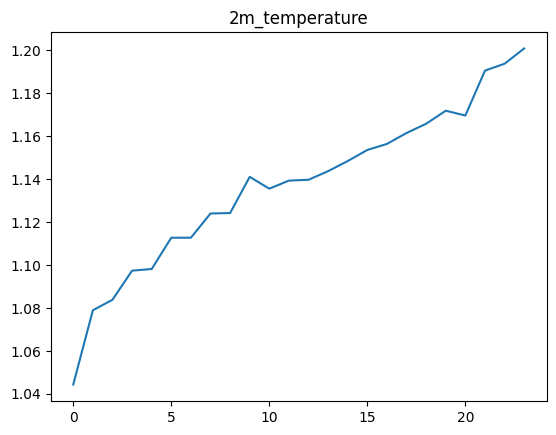

torch.Size([24])


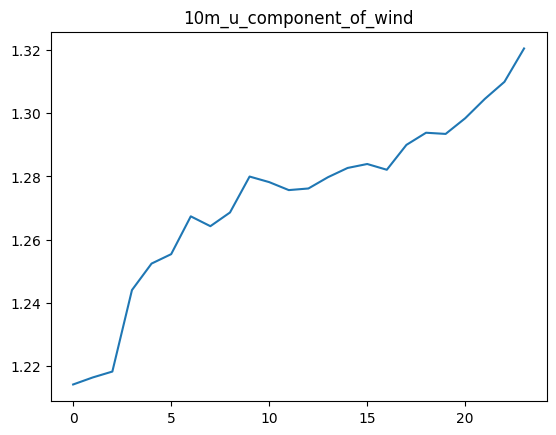

torch.Size([24])


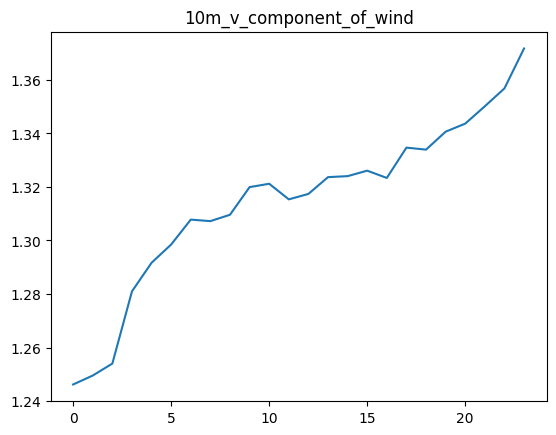

torch.Size([24])


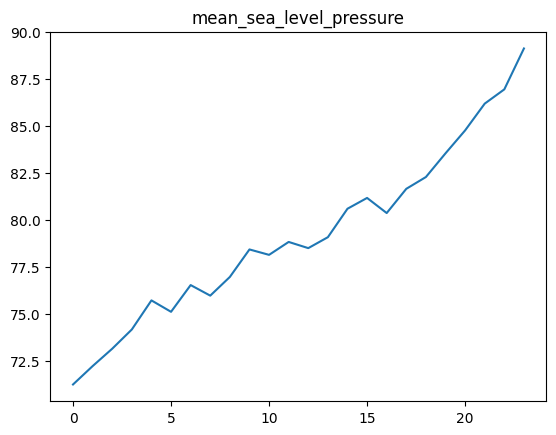

torch.Size([24])


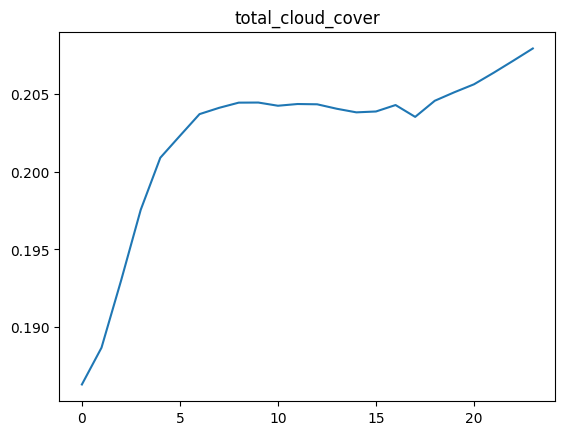

torch.Size([24])


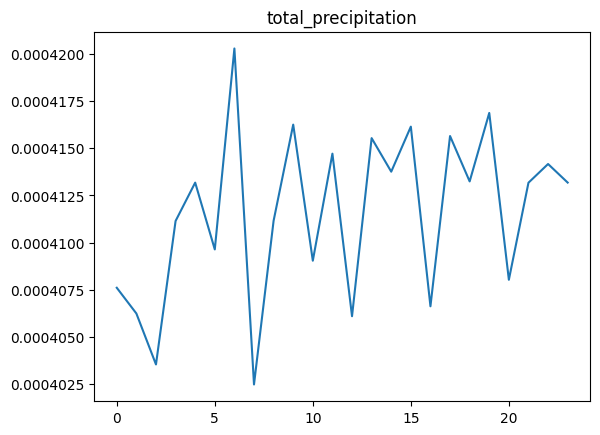

In [13]:
for i, var in enumerate(config.training.surface_variable):
        idx = len(config.training.air_variable) * len(config.training.levels) + i
        visualize(torch.sqrt(result[idx]), var, isAIR=False)

torch.Size([24])


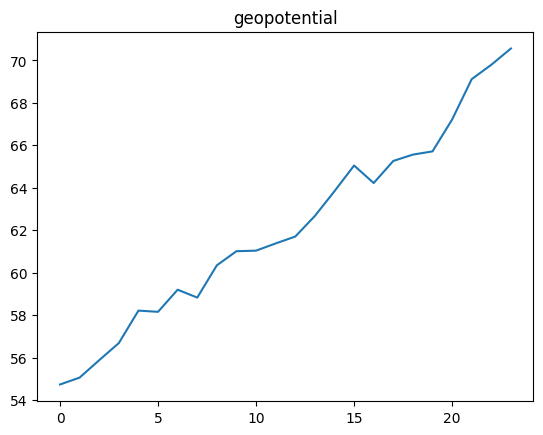

torch.Size([24])


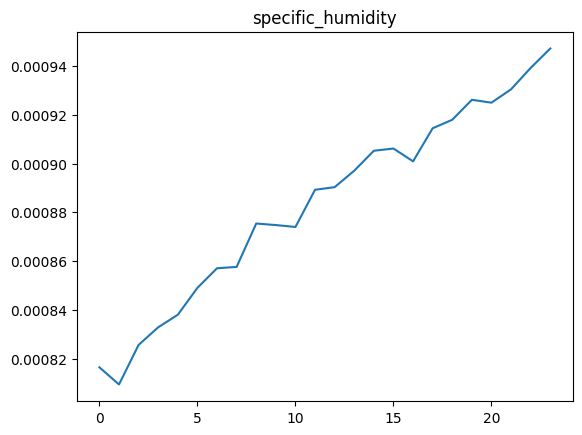

torch.Size([24])


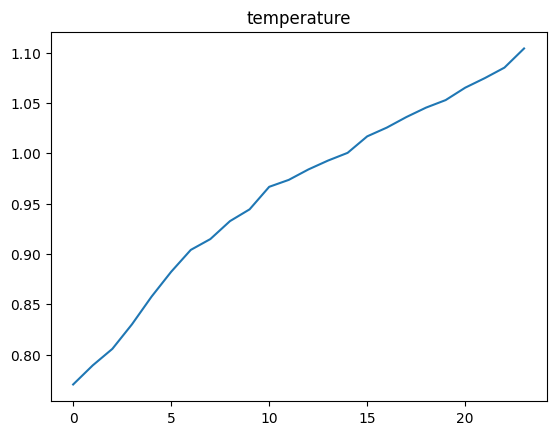

torch.Size([24])


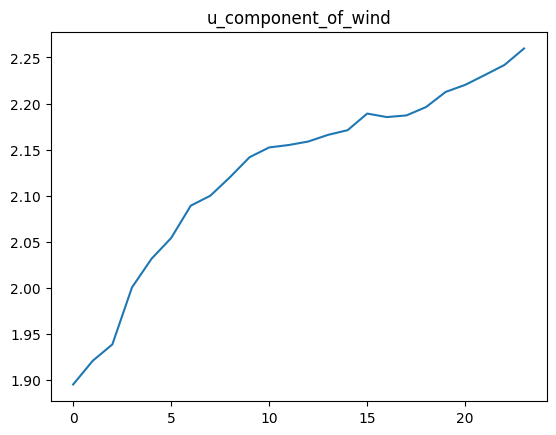

torch.Size([24])


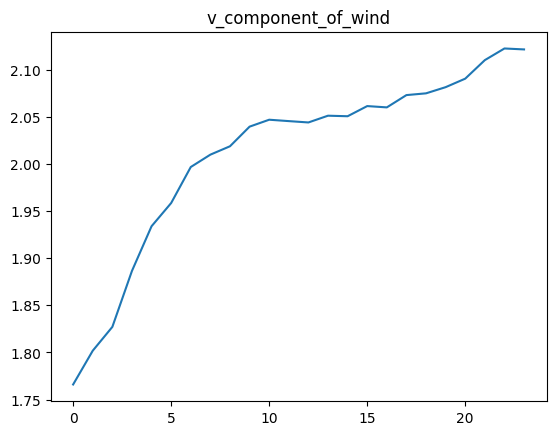

torch.Size([24])


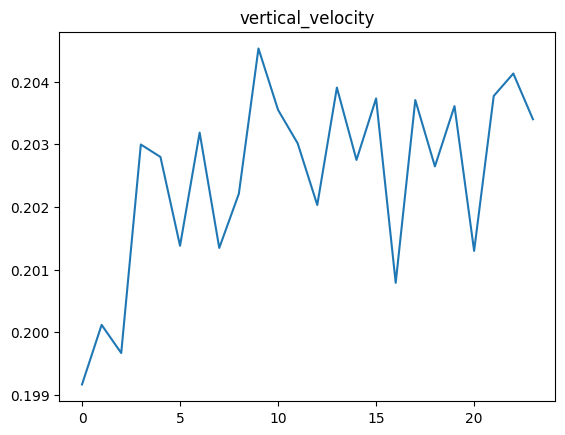

In [12]:
for idx, var in enumerate(config.training.air_variable):
        air_list = [ ((idx)*len(config.training.levels)) + i for i in range(len(config.training.levels))]
        visualize(torch.sqrt(result[air_list]), var, isAIR=True, level=-3)